In [1]:
import numpy as np

import sys
sys.path.append("..")
from nc_suite import *

In [2]:
# Create img and labels
from torchvision import datasets
import cv2

img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

mnist = datasets.MNIST('data', train=True, download=True)
img = np.asarray(mnist[2][0])

label = np.copy(img) # shallow copy is fine, since it isn't python objects inside
label[label>0] = 1

In [3]:
# Really simple weighting methods...
from sklearn import feature_extraction
delta = 10

sk_W = feature_extraction.image.img_to_graph(img, return_as=np.ndarray) # adjaceny matrix
sk_W2 = feature_extraction.image.img_to_graph(img)
sk_W2.data = np.exp(-sk_W2.data ** 2 / (2. * delta ** 2))
sk_W2 = sk_W2.toarray()

i_W = intensity_weight_matrix(img)
p_W = positional_weight_matrix(img)
pi_W = intens_posit_wm(img)
man_bin_W_1 = manual_weights_binary(img, r=1)
man_abs_W_1 = manual_weights_abs(img, r=1)
man_bin_W_10 = manual_weights_binary(img, r=10)
man_abs_W_10 = manual_weights_abs(img, r=10)

sk_W_baby = feature_extraction.image.img_to_graph(img_baby, return_as=np.ndarray)
sk_W2_baby = feature_extraction.image.img_to_graph(img_baby)
sk_W2_baby.data = np.exp(-sk_W2_baby.data ** 2 / (2. * delta ** 2))
sk_W2_baby = sk_W2_baby.toarray()

i_W_baby = intensity_weight_matrix(img_baby)
p_W_baby = positional_weight_matrix(img_baby)
pi_W_baby = intens_posit_wm(img_baby)
man_bin_W_baby_1 = manual_weights_binary(img_baby, r=1)
man_abs_W_baby_1 = manual_weights_abs(img_baby, r=1)
man_bin_W_baby_10 = manual_weights_binary(img_baby, r=10)
man_abs_W_baby_10 = manual_weights_abs(img_baby, r=10)

# TODO: https://github.com/avnCode/Image_Segmentation/blob/main/nCut.ipynb
# tests similar to

# TODO: test the output being multiplied by D^-0.5  // the NC paper says it is the wrong thing to do (average cuts) but most libraries implement it as this for clustering?

# TODO: double check this stuff..
# TODO: do the eigenvector calcualtion multiple times to ensure it isn't a weird problem like the first one doesn't do anything but later cuts on the smaller region do...
# page 5 of SM-ncut.pdf
# impose a stability criterion on the partition, ignore all eigenvectors with smoothly varing eigenvecor values.
# compute histogram of eigenvector values and compute ratio between min and max. When continuously varying this will have a high ratio as they ar all the same.

/mnt/c/Users/garth/Desktop/DDN/notebooks/../nc_suite.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
  W[u][v] = W[u][v] = np.abs(I[u] - I[v]) # Symmetric


In [4]:
from collections import OrderedDict


weights = OrderedDict(
    img=img, label=label, sk_W=sk_W, sk_W2=sk_W2, i_W=i_W, p_W=p_W, pi_W=pi_W, 
    man_bin_W_1=man_bin_W_1, man_abs_W_1=man_abs_W_1, man_bin_W_10=man_bin_W_10, man_abs_W_10=man_abs_W_10,
    
    img_baby=img_baby, blank=np.zeros_like(img_baby), sk_W_baby=sk_W_baby, sk_W2_baby=sk_W2_baby, i_W_baby=i_W_baby, p_W_baby=p_W_baby, pi_W_baby=pi_W_baby, 
    man_bin_W_baby_1=man_bin_W_baby_1, man_abs_W_baby_1=man_abs_W_baby_1, man_bin_W_baby_10=man_bin_W_baby_10, man_abs_W_baby_10=man_abs_W_baby_10
)

for key,value in weights.items(): #eigsh expects float or double
    weights[key] = value.astype(float)

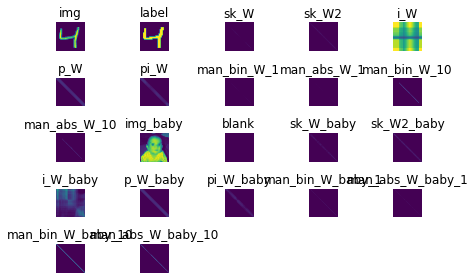

In [5]:
plt.rcParams["figure.figsize"] = (12,12) # specify the size for this cell
plot_images([weight for weight in weights.values()], 
            [key for key in weights.keys()],
            colmns=5)

In [6]:
# test = np.array([[1,1,0,0],
#                 [1,1,0,0],
#                 [1,1,1,0],
#                 [1,1,1,1]])

# test_w = manual_weights_abs(test, r=10)

# def norm_laplacian(W):
#     L = W + W.T # ensure symmetric
#     np.fill_diagonal(L,0)
#     D = L.sum(0) # symmetric so axis doesn't matter
#     isolated_mask = (D == 0)
#     D = np.where(isolated_mask, 1, np.sqrt(D))
#     L = L/D
#     L = L/D[:, np.newaxis]
#     L = L * -1
#     setdiag(L, 1 - isolated_mask)
#     return L, D

# laplacians = OrderedDict((key, norm_laplacian(value)) for key,value in weights.items() if key not in ['img','img_baby', 'label', 'blank'])

In [7]:
# plt.rcParams["figure.figsize"] = (8,8) # specify the size for this cell
# plot_images([x[0] for x in laplacians.values()], 
#             [y for y in laplacians.keys()],
#             colmns=9)

In [8]:
# to store multiple different methods
from functools import partial

# the methods to store
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse_linalg

def deterministic_vector_sign_flip(u):
    # from https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/extmath.py#L1097
    max_abs_rows = np.argmax(np.abs(u), axis=1)
    signs = np.sign(u[range(u.shape[0]), max_abs_rows])
    u *= signs[:, np.newaxis]
    return u

def shift_invert(input, func):
    input = input * -1
    return func(input)

# This initialization model has been chosen to be consistent with
# the ARPACK one as another initialization can lead to convergence issues.
# v0 = random_state.uniform(-1, 1, size)
# from https://github.com/scikit-learn/scikit-learn/blob/2a2772a87b6c772dc3b8292bcffb990ce27515a8/sklearn/utils/_arpack.py#L4
np.random.seed(0)
v0 = np.random.uniform(-1,1,28*28)

# These require shift_invert on the input as sigma shift is used
shift_eigsh_1 = partial(sparse_linalg.eigsh, k=2, which='LM', sigma=1, max_iter=200)
shift_eigsh_2 = partial(sparse_linalg.eigsh, k=25, which='LM', sigma=1, max_iter=200)

# Ordered dict to iterate over
eigs_options = OrderedDict(
    
    # TODO: also check the spectrum of eigenvalues...
    # should be 0 to 2, which means shift invert by 1 for max 1.0 for faster compute    
    np_eigh = np.linalg.eigh,
    
    eigh_base = partial(linalg.eigh),
    eigh_cff = partial(linalg.eigh, check_finite=False),
        
    # try for SM and SA, but if return eigenvectors True, should use SA anyway
    sparse_eigsh_1 = partial(sparse_linalg.eigsh, k=2, which='SA'),
    sparse_eigsh_2 = partial(sparse_linalg.eigsh, k=25, which='SM'),
    sparse_eigsh_3 = partial(sparse_linalg.eigsh, k=2, which='SM'),
    sparse_eigsh_shift_1 = partial(shift_invert, func=shift_eigsh_1),
    sparse_eigsh_shift_2 = partial(shift_invert, func=shift_eigsh_2)
    
    # lobpcg(L, X, Y=Y, largest=False, tol=1e-3)
    # from bottom of https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.laplacian.html
    # where each param is explained there..
)

def setdiag(m,d):
    step = len(d) + 1
    m.flat[::step] = d

# non symm laplacian
def non_symm(W):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, d)

    A = D - W
    return A

# symm laplacian 1
def symm1(W):
    d = W.sum(0)
    D = np.diag(W)
    d2 = np.reciprocal(np.sqrt(d2.data, where=d2>0), where=d2>0)
    A = d2 * (D - W) * d2
    return A

# symm laplacian 2
def symm2(W):
    L = W + W.T # ensure symmetric
    np.fill_diagonal(L,0)
    D = L.sum(0) # symmetric so axis doesn't matter
    isolated_mask = (D == 0)
    D = np.where(isolated_mask, 1, np.sqrt(D))
    L = L/D
    L = L/D[:, np.newaxis]
    L = L * -1
    setdiag(L, 1 - isolated_mask)
    return L

laplace_options = OrderedDict(
    non_symm = non_symm,
    symm1 = symm1,
    symm2 = symm2
)

In [9]:
from tqdm import tqdm
    
# solve with any given eigensolver and laplacian approach
def generic_solve(W, laplace,solver):
    L = laplace(np.copy(W))
    _, eig_vectors = solver(L)
    
    output = eig_vectors[:, 1]
    deterministic_vector_sign_flip(output)
    output = output.reshape(28,28)
    return output

outputs = []
outputs_labels = []
errors = []
for eig_name, eig_func in eigs_options.items(): # for each eigensolver    
    for laplace_name, laplace_func in laplace_options.items(): # and each laplacian type
        for weight_name, weight in (pbar := tqdm(weights.items())): # and each weight
            pbar.set_description(f'{eig_name} - {laplace_name}')
            if weight_name not in ['img','img_baby', 'label', 'blank']: # that isn't some other array
                try:
                    outputs.append(generic_solve(weight, laplace_func, eig_func)) # solve and append its output
                    outputs_labels.append(f'{eig_name} - {laplace_name} - {weight_name}')
                except:
                    errors.append(f'{eig_name} - {weight_name}')

sparse_eigsh_shift_2 - symm2: 100%|██████████| 22/22 [00:00<00:00, 98.74it/s]

erorrs on:
['np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W_1', 'np_eigh - man_bin_W_10', 'np_eigh - man_abs_W_10', 'np_eigh - sk_W_baby', 'np_eigh - sk_W2_baby', 'np_eigh - i_W_baby', 'np_eigh - p_W_baby', 'np_eigh - pi_W_baby', 'np_eigh - man_bin_W_baby_1', 'np_eigh - man_abs_W_baby_1', 'np_eigh - man_bin_W_baby_10', 'np_eigh - man_abs_W_baby_10', 'np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W_1', 'np_eigh - man_bin_W_10', 'np_eigh - man_abs_W_10', 'np_eigh - sk_W_baby', 'np_eigh - sk_W2_baby', 'np_eigh - i_W_baby', 'np_eigh - p_W_baby', 'np_eigh - pi_W_baby', 'np_eigh - man_bin_W_baby_1', 'np_eigh - man_abs_W_baby_1', 'np_eigh - man_bin_W_baby_10', 'np_eigh - man_abs_W_baby_10', 'np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W

In [17]:
print('erorrs on:')
print(errors)
print(len(errors))
print(len(outputs))

plt.rcParams["figure.figsize"] = (28,28) # specify the size for this cell
plot_images(outputs, outputs_labels, colmns=9)

erorrs on:
['np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W_1', 'np_eigh - man_bin_W_10', 'np_eigh - man_abs_W_10', 'np_eigh - sk_W_baby', 'np_eigh - sk_W2_baby', 'np_eigh - i_W_baby', 'np_eigh - p_W_baby', 'np_eigh - pi_W_baby', 'np_eigh - man_bin_W_baby_1', 'np_eigh - man_abs_W_baby_1', 'np_eigh - man_bin_W_baby_10', 'np_eigh - man_abs_W_baby_10', 'np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W_1', 'np_eigh - man_bin_W_10', 'np_eigh - man_abs_W_10', 'np_eigh - sk_W_baby', 'np_eigh - sk_W2_baby', 'np_eigh - i_W_baby', 'np_eigh - p_W_baby', 'np_eigh - pi_W_baby', 'np_eigh - man_bin_W_baby_1', 'np_eigh - man_abs_W_baby_1', 'np_eigh - man_bin_W_baby_10', 'np_eigh - man_abs_W_baby_10', 'np_eigh - sk_W', 'np_eigh - sk_W2', 'np_eigh - i_W', 'np_eigh - p_W', 'np_eigh - pi_W', 'np_eigh - man_bin_W_1', 'np_eigh - man_abs_W

<Figure size 2016x2016 with 0 Axes>

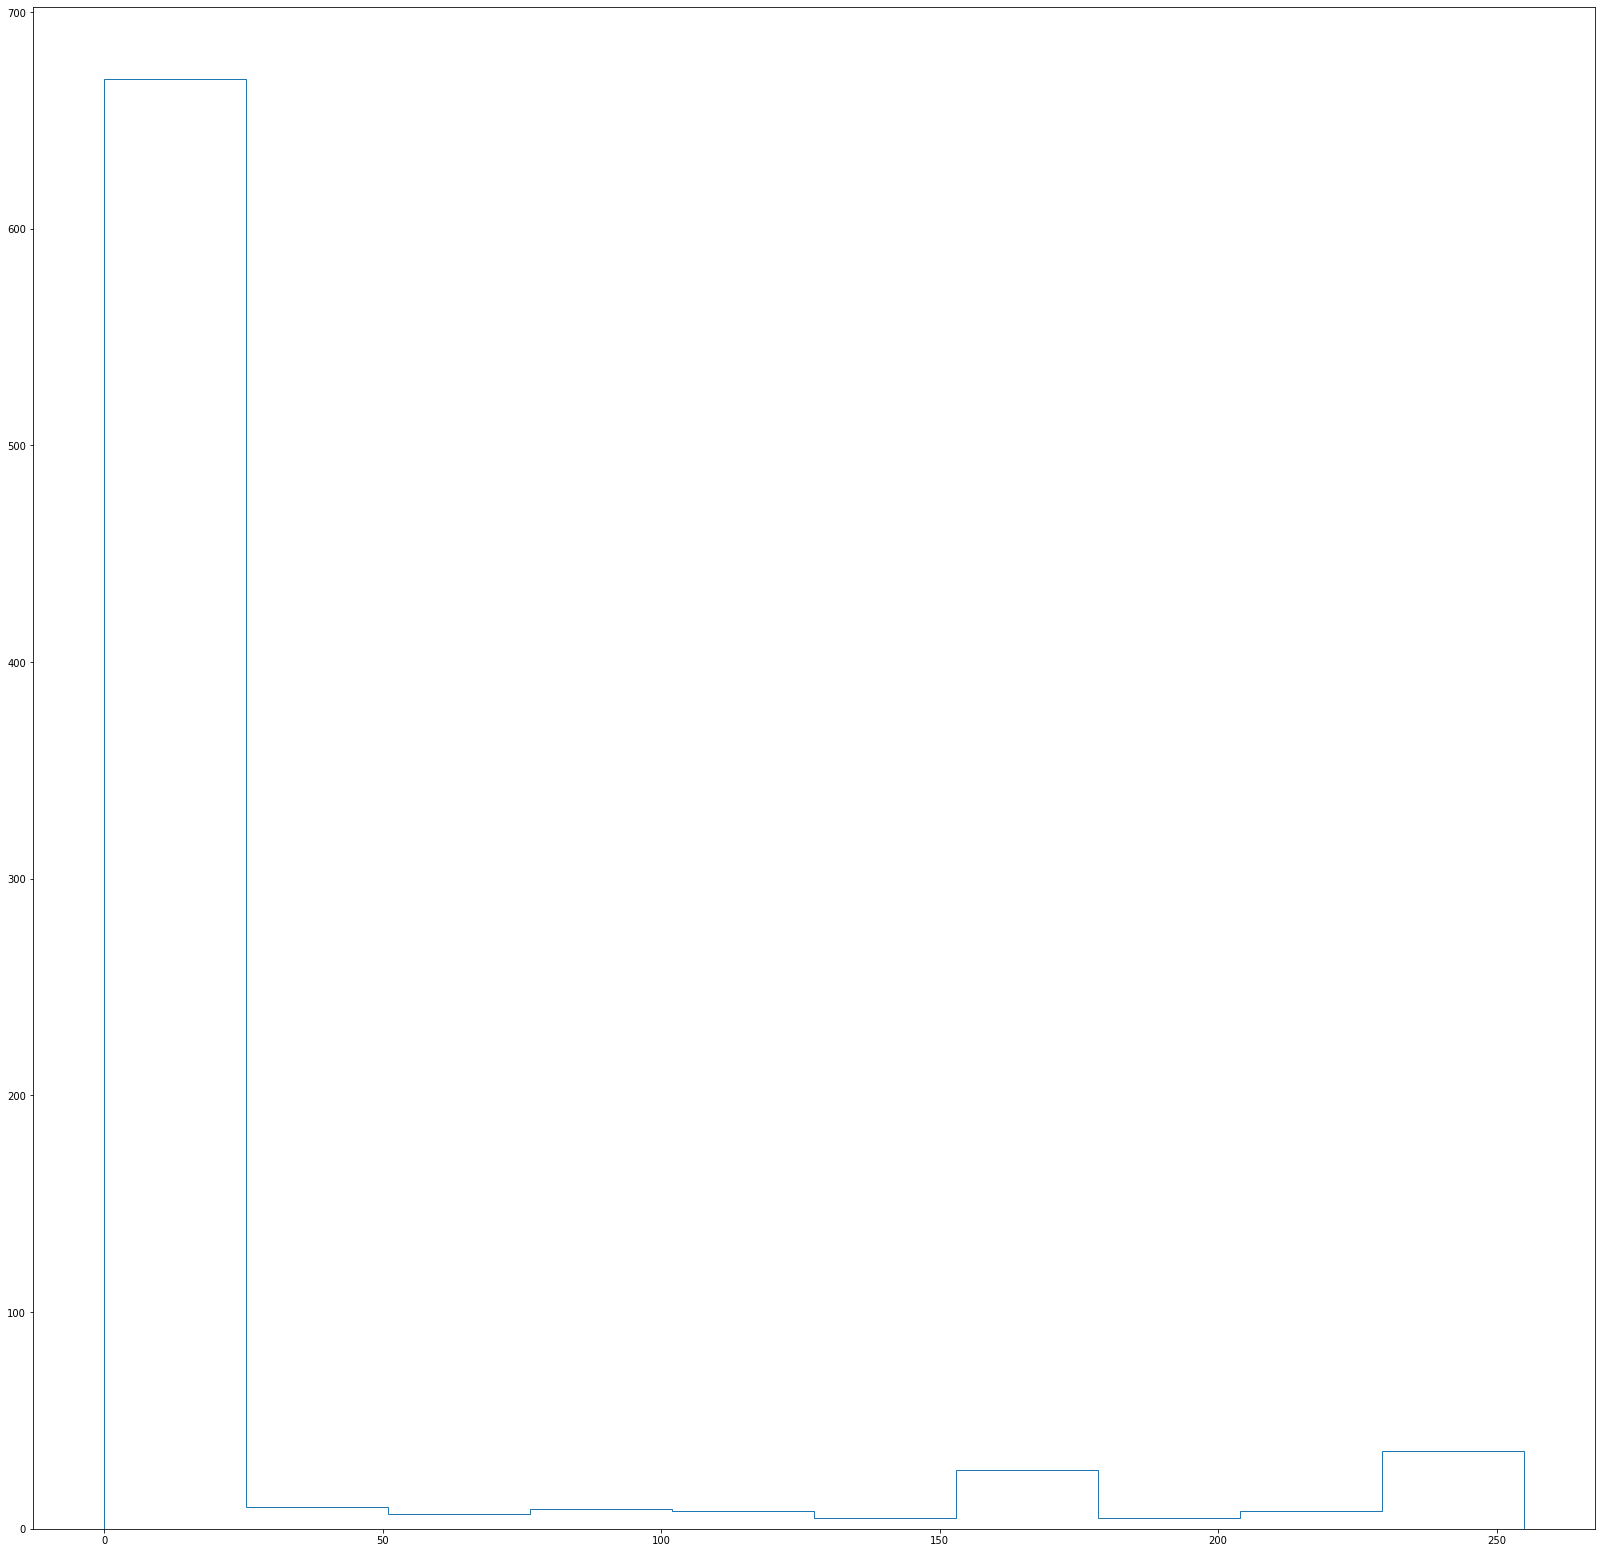

[669  10   7   9   8   5  27   5   8  36]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]


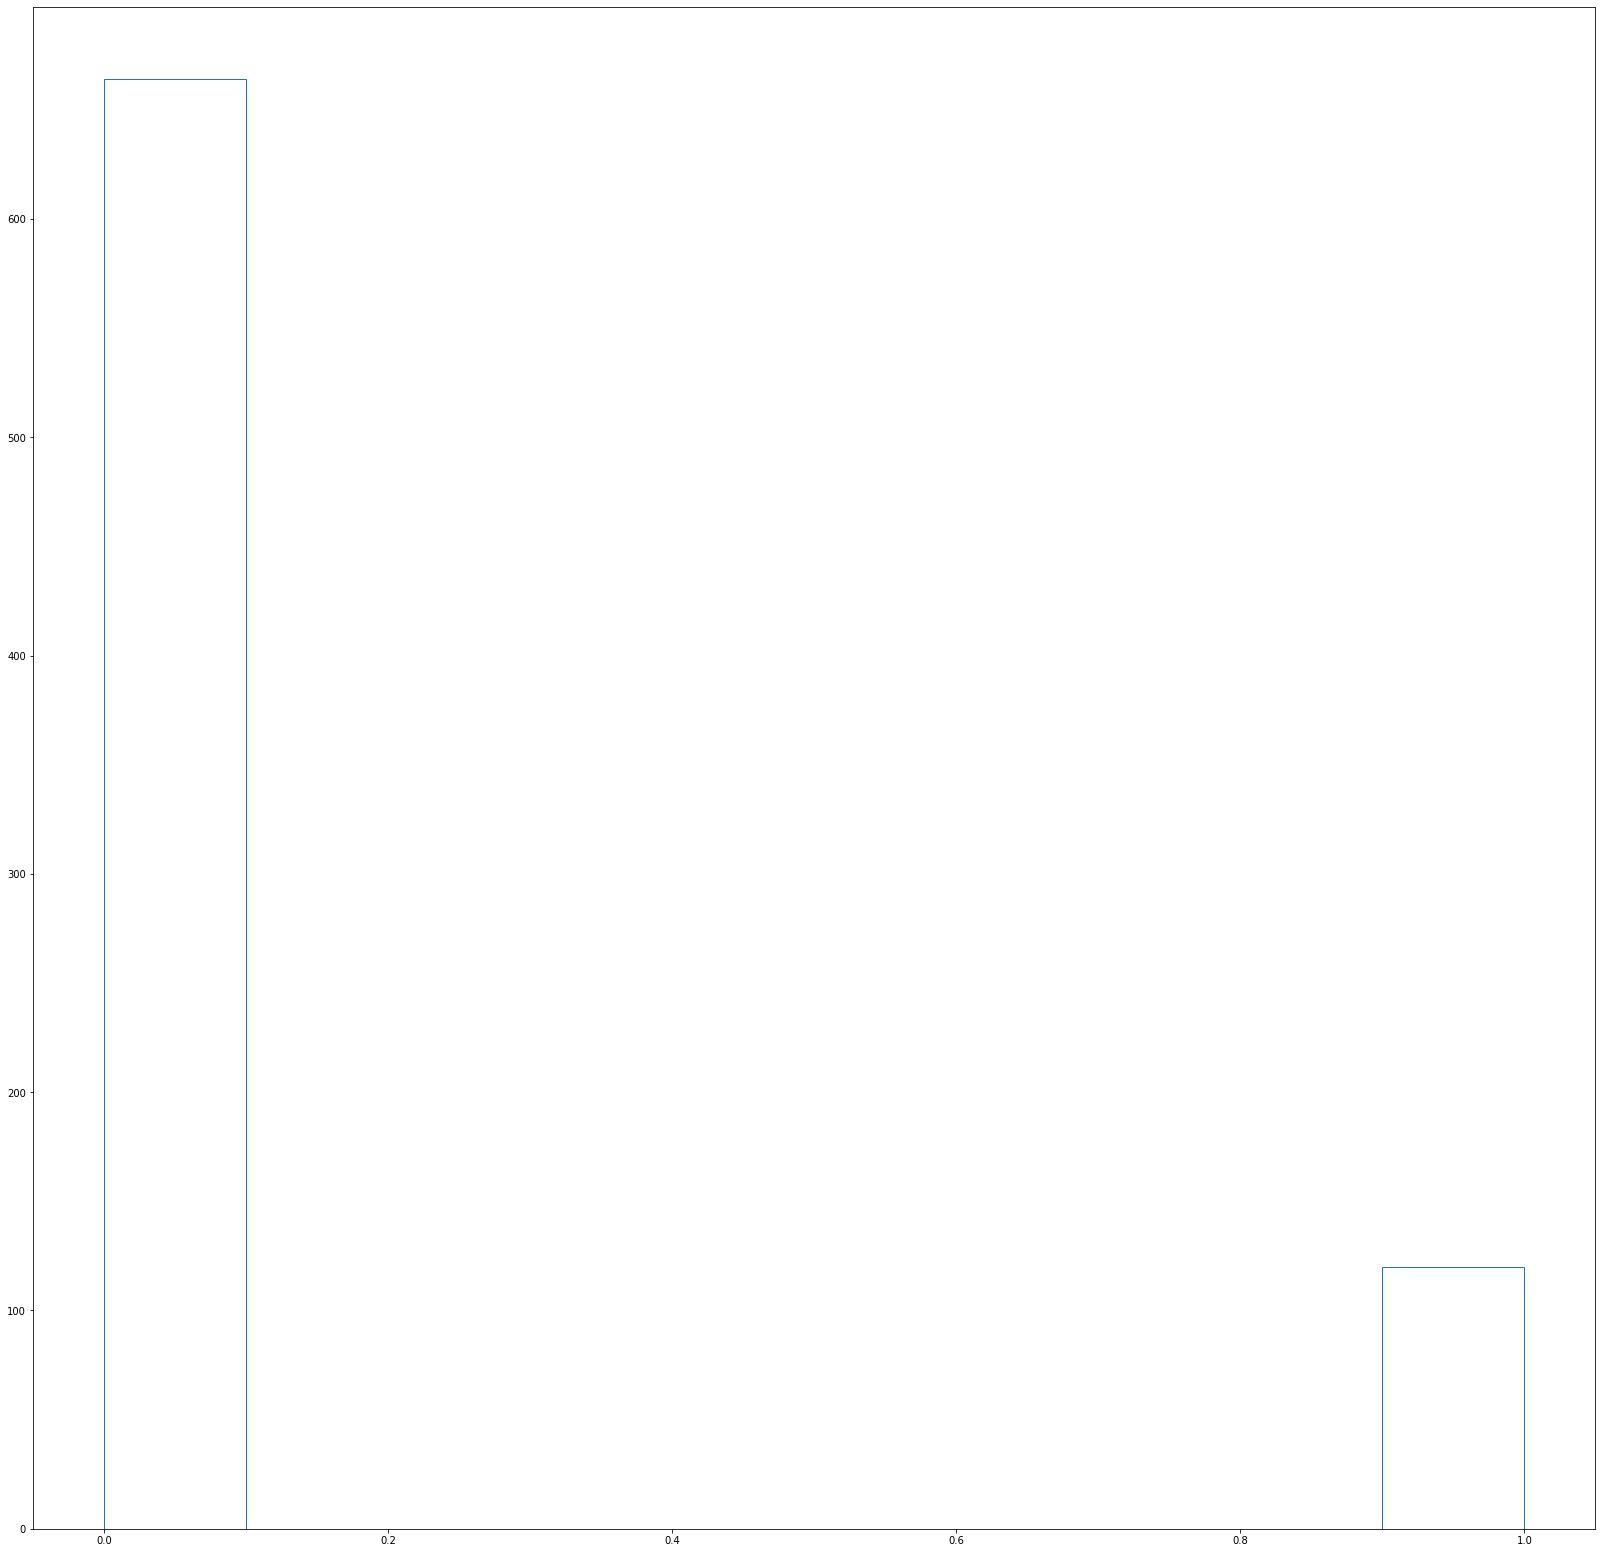

[664   0   0   0   0   0   0   0   0 120]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [11]:
counts, bins = np.histogram(img)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

counts, bins = np.histogram(label)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)